In [32]:
import os
import nibabel as nib
import numpy as np
from __future__ import division
import tricubic # place tricubic.so in current folder

import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
def get_bbox(img):
    '''
    Input: img, an object from nib.load
    
    output: BB  - a [2 x 3] array of the min and max X, Y, and Z coordinates {mm},
%           i.e. BB = [minX minY minZ; maxX maxY maxZ].
    '''
    
    d = img.shape
    corners = np.array([[1, 1, 1, 1], 
                        [1, 1, d[2], 1],
                        [1, d[1], 1, 1],
                        [1, d[1], d[2], 1],
                        [d[0], 1, 1, 1],
                        [d[0], 1, d[2], 1],
                        [d[0], d[1], 1, 1],
                        [d[0], d[1], d[2], 1]]).T
    XYZ = img.affine[:3,:].dot(corners)
    BB = np.array([[XYZ.min(axis=1)],[XYZ.max(axis=1)]]).reshape(2,3)
    
    return BB

In [34]:
def get_coord(x, y, z, img):
    
    bb = get_bbox(img)
    
    [nx, ny ,nz] = img.shape
    
    newx = (x - bb[0,0])/(bb[1,0]-bb[0,0]) * (nx-1)
    newy = (y - bb[0,1])/(bb[1,1]-bb[0,1]) * (ny-1)
    newz = (z - bb[0,2])/(bb[1,2]-bb[0,2]) * (nz-1)
    
    return (newx, newy, newz)
    

In [8]:
hackDir = '/home/rajat/Dropbox/Brainhack/'

# Load the subject
T1 = nib.load(os.path.join(hackDir,'subs.nii'))
dataT1 = T1.get_data()

# Load the deformation field               
defFile = nib.load(os.path.join(hackDir,'y_subs.nii'))
defField = defFile.get_data()

In [41]:
dataT1.shape

(240, 240, 220)

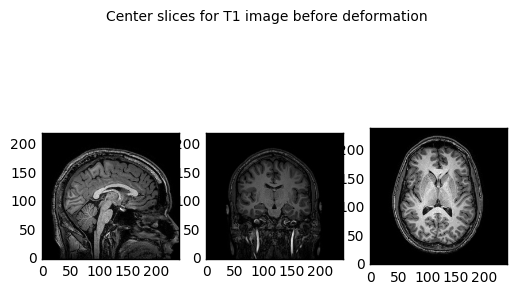

In [44]:
 def show_slices(slices):
        """ Function to display row of image slices """
        fig, axes = plt.subplots(1, len(slices))
        for i, slice in enumerate(slices):
            axes[i].imshow(slice.T, cmap="gray", origin="lower")

slice_0 = dataT1[120, :, :]
slice_1 = dataT1[:, 120, :]
slice_2 = dataT1[:, :, 110]
show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for T1 image before deformation")  

In [35]:
# Deconvolve the coefficients for interpolation (do this once for the subject)

nx, ny, nz = T1.shape
f = np.zeros(T1.shape)
f[:,:,:] = dataT1[:,:,:] # dataT1 is memmap object, so converting to numpy.ndarray 

ip = tricubic.tricubic(list(f), [nx, ny, nz]) #initialize interpolator with input data on cubic grid

In [37]:
# Once the above interpolator coeff have been extracted 
# you can add "noise" to defField to have different instances of the augmented data

nx, ny, nz = defFile.shape[:3]
deformed_img = np.zeros(defFile.shape[:3])

for i in range(nx):
    for j in range(ny):
        for k in range(nz):
            xnew, ynew, znew = get_coord(defField[i,j,k,0,0], defField[i,j,k,0,1], defField[i,j,k,0,2], T1)
            deformed_img[i,j,k] = ip.ip([xnew, ynew, znew]) #interpolate to deformed space

In [ ]:
slice_0 = deformed_img[120, :, :]
slice_1 = deformed_img[:, 120, :]
slice_2 = deformed_img[:, :, 110]
show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for T1 image before deformation") 

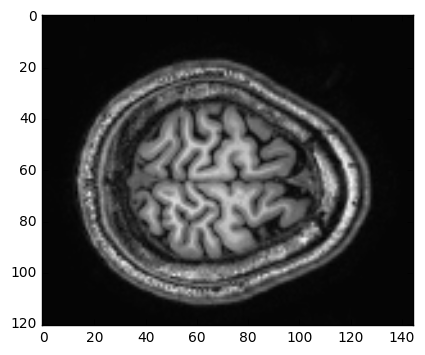

In [39]:
defFile